# EEG-Based Schizophrenia Classification Using GAF and MDA
The EEG data from a sensory task involving control and schizophrenic groups with 81 total subjects.

The dataset is in two parts:
- https://www.kaggle.com/datasets/broach/button-tone-sz
- https://www.kaggle.com/datasets/broach/buttontonesz2

This work transforms this EEG data into normalised 3072-point EEG segments and applies Gramian Angular Summation Field, and resizes to 224x224 grayscale images using OpenCV to capture temporal patterns.
This notebook experiments with two pipelines:
1. MDA Pipeline: Uses MDA for dimensionality reduction with optimised ranks, followed by traditional classifiers.
2. CNN Pipeline: Employs a lightweight 3-layer Convolutional Neural Network with data augmentation, trained end-to-end on GAF images using PyTorch with CUDA acceleration.

In [16]:
import pandas as pd
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import os
from pyts.image import GramianAngularField
from collections import Counter
import matplotlib.pyplot as plt
import warnings
from CNNTrainer import CNNTrainer
from MDATrainer import MDATrainer
from CVFold import CVFold
from utils import load_processed_data, save_processed_data, save_gaf_images, load_gaf_images
warnings.filterwarnings('ignore')

## Load EEG as time series
Load time-series data from the `EEG` folder, `demographic.csv` contains the group each subject belongs to.

The function completes these steps:
  1. Load demographics with binary labels (0=healthy, 1=schizophrenia).
  2. Find subject folders.
  3. For each subject: 
    - Load raw CSV
    - Extract columns 4-12 as channels
    - Split each channel into ≤3 segments of 3072 points
    - Filter for quality (std >0.1, >10 unique values).

It returns Numpy arrays of time series segments (all 3072 pts) and matching labels.

In [ ]:
print("Checking for existing cache files...")
time_series_data, labels = load_processed_data(cache_file='processed_eeg_cache.pkl')
if time_series_data is not None:
    print("Processed EEG data loaded from cache. Skipping subject processing.")
else:
    print("No processed cache found. Processing subjects...")
    print("Loading real EEG time series data...")
    base_path='EEG'

    demographic_data = pd.read_csv(os.path.join(base_path, 'demographic.csv'))
    demographic_data.columns = demographic_data.columns.str.strip()
    
    all_time_series = []
    all_labels = []
    
    existing_subjects = []
    for item in os.listdir(base_path):
        if item.endswith('.csv') and os.path.isdir(os.path.join(base_path, item)):
            try:
                subject_id = int(item.replace('.csv', ''))
                existing_subjects.append(subject_id)
            except ValueError:
                continue

    existing_subjects.sort()
    print(f"Found {len(existing_subjects)} subject folders: {existing_subjects}")

    # Process each existing subject
    for subject_id in existing_subjects:
        subject_demo = demographic_data[demographic_data['subject'] == subject_id]
        if len(subject_demo) == 0:
            print(f"No demographic data for subject {subject_id}")
            continue
        
        subject_group = subject_demo['group'].iloc[0]
        # 1 = schizophrenia, 0 = control
        label = 1 if subject_group == 1 else 0
        
        subject_folder = os.path.join(base_path, f'{subject_id}.csv')
        subject_file = os.path.join(subject_folder, f'{subject_id}.csv')
        
        if not os.path.exists(subject_file):
            continue
        
        try:
            subject_data = pd.read_csv(subject_file, header=None)
            
            print(f"Subject {subject_id}: shape {subject_data.shape}, group {subject_group}")
            
            # Columns 4-12 (up to 9 channels)
            potential_eeg_columns = list(range(4, min(13, subject_data.shape[1])))
            
            for col_idx in potential_eeg_columns:
                if col_idx >= subject_data.shape[1]:
                    break
                    
                eeg_channel_data = subject_data.iloc[:, col_idx].dropna().values
                
                if len(eeg_channel_data) >= 3072:
                    # Use overlapping windows
                    window_size = 3072
                    step_size = 1536  # 50% overlap (3072 // 2)
                    
                    max_windows = 6
                    num_windows = min(max_windows, (len(eeg_channel_data) - window_size) // step_size + 1)
                    
                    for window in range(num_windows):
                        start_idx = window * step_size
                        end_idx = start_idx + window_size
                        
                        if end_idx <= len(eeg_channel_data):
                            time_series = eeg_channel_data[start_idx:end_idx]
                            
                            if len(np.unique(time_series)) > 10 and np.std(time_series) > 0.1:
                                all_time_series.append(time_series)
                                all_labels.append(label)
                            
                            if subject_id <= 2 and col_idx == potential_eeg_columns[0]:  # Debug
                                print(f"    Column {col_idx} window {window}: {len(time_series)} points, std={np.std(time_series):.2f}")

        except Exception as e:
            print(f"Error loading subject {subject_id}: {e}")
            continue

    print(f"Loaded {len(all_time_series)} real time series windows")

    time_series_data = np.array(all_time_series, dtype=object)
    labels = np.array(all_labels)

    save_processed_data(time_series_data, labels)

Checking for existing cache files...
Loaded 4374 cached processed_eeg from processed_eeg_cache.pkl
Label distribution: [1728 2646]
Processed EEG data loaded from cache. Skipping subject processing.


## GAF Image Creation
Turn EEG time series into 2D GAF images, for each series:
1. Converts to floats and removes NaN/infinite values.
2. Skips if <10 points remain.
3. Resizes to 224 points using interpolation if needed.
4. Normalises to [-1, 1] and creates a 224x224 GAF image.

Returns arrays of GAF images (224x224) and matching labels.

In [ ]:
gaf_images, gaf_labels = load_gaf_images(cache_file='gaf_images_cache.pkl')
if gaf_images is not None:
    print("GAF images loaded from cache. Skipping GAF processing.")
else:
    print("No GAF cache found. Creating GAF images...")
    image_size=224

    print(f"Creating GAF images from {len(time_series_data)} real time series...")

    gaf = GramianAngularField(image_size=image_size, method='summation')
    images = []
    valid_labels = []

    for i, ts in enumerate(time_series_data):
        try:
            ts = np.array(ts, dtype=float)
            ts = ts[np.isfinite(ts)]

            # Skip if not enough valid points
            if len(ts) < 10:
                continue

            # Resize to exactly image_size points for GAF
            if len(ts) != image_size:
                indices = np.linspace(0, len(ts)-1, image_size)
                ts_resampled = np.interp(indices, np.arange(len(ts)), ts)
            else:
                ts_resampled = ts

            # Normalize to [-1, 1] range as required by GAF
            if ts_resampled.max() != ts_resampled.min():
                ts_norm = 2 * (ts_resampled - ts_resampled.min()) / (ts_resampled.max() - ts_resampled.min()) - 1
            else:
                ts_norm = np.zeros_like(ts_resampled)

            ts_norm = np.clip(ts_norm, -1, 1)

            gaf_image = gaf.transform(ts_norm.reshape(1, -1))[0]

            images.append(gaf_image)
            valid_labels.append(labels[i])

            if (i + 1) % 50 == 0:
                print(f"Processed {i + 1}/{len(time_series_data)} time series")

        except Exception as e:
            print(f"Error processing time series {i}: {e}")
            continue

    gaf_images, gaf_labels = np.array(images), np.array(valid_labels)

    save_gaf_images(gaf_images, gaf_labels)

print("Data loading complete.")

Loaded 4374 cached gaf_images from gaf_images_cache.pkl
Label distribution: [1728 2646]
Image shape: (224, 224)
GAF images loaded from cache. Skipping GAF processing.
Data loading complete.


In [19]:
k_folds = 3
random_state = 2003

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)
fold_data = []

print(f"Creating {k_folds} fold cross-validation splits")
print(f"Total samples: {len(gaf_images)}")

for fold, (train_val_idx, test_idx) in enumerate(skf.split(gaf_images, gaf_labels)):
    # Split 80% train / 20% val - SAME for both CNN and MDA
    train_data, val_data, train_lbls, val_lbls = train_test_split(
        gaf_images[train_val_idx], gaf_labels[train_val_idx],
        test_size=0.2, random_state=random_state, stratify=gaf_labels[train_val_idx]
    )
    
    # Shared test data
    test_data = gaf_images[test_idx]
    test_lbls = gaf_labels[test_idx]

    print(f"  Fold {fold + 1} - Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
    
    fold_data.append(CVFold(
        fold + 1,
        train_data, train_lbls,
        val_data, val_lbls,
        test_data, test_lbls,
    ))

Creating 3 fold cross-validation splits
Total samples: 4374
  Fold 1 - Train: 2332, Val: 584, Test: 1458
  Fold 2 - Train: 2332, Val: 584, Test: 1458
  Fold 3 - Train: 2332, Val: 584, Test: 1458


## MDA Pipeline
The MDA pipeline applies dimensionality reduction to EEG GAF images using MDA, and classifies the group the image is from using a final traditional classifier.

The setup runs a nested cross-validation scheme with 3 outer folds. Inside each fold it grid searches over MDA ranks to pick the optimal one - validated with 1-NN and then hyperparameter tunes the classifiers.

This work uses an MDA implementation outlined in [1], using the code provided in: **https://github.com/tensorly/Proceedings_IEEE_companion_notebooks/blob/master/MDA.ipynb**.

After reduction the following classifiers are tested to find the best classification accuracy: SVM (both RBF and Linear), RandomForest, k-NN, NaiveBayes, LogisticRegression, MLP, Decision Tree.

In [20]:
ranks = [8, 16, 24, 32, 64]
total_iters = 5

print(f"Using Multi-Classifier MDA Pipeline (ranks={ranks}, iters={total_iters}, folds={k_folds})")
print(f"Dataset size: {len(gaf_images)} images of shape {gaf_images[0].shape}")
print(f"Label distribution: {np.bincount(gaf_labels)}")

y = gaf_labels.astype(int)

classifiers = {
    'SVM': (SVC(random_state=random_state), {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}),
    'RandomForest': (RandomForestClassifier(random_state=random_state, n_jobs=-1), {'n_estimators': [50, 100], 'max_depth': [None, 10]}),
    'KNN': (KNeighborsClassifier(metric='euclidean', n_jobs=-1), {'n_neighbors': [1, 3, 5, 10]}),
    'LogisticRegression': (LogisticRegression(random_state=random_state, max_iter=1000), {'C': [0.1, 1, 10]}),
    'MLP': (MLPClassifier(random_state=random_state, max_iter=500), {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]}),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}),
}
mda_test_accuracies = []
mda_fold_results = []

for cv_fold in fold_data:
    fold_num = cv_fold.fold
    print(f"\nFold {fold_num}/{k_folds}")

    mda_trainer = MDATrainer(classifiers, ranks, total_iters=total_iters)

    best_rank, best_clf, best_score = mda_trainer.run(cv_fold)

    print(f"Best rank: {best_rank}, best classifier: {best_clf} (val score: {best_score:.4f})")

    ###
    X_train_scaled, X_test_scaled, model = mda_trainer.apply_mda_and_scale(cv_fold.train_data, cv_fold.train_lbls, cv_fold.test_data, cv_fold.test_lbls, best_rank)
    best_clf.fit(X_train_scaled, cv_fold.train_lbls)
    test_acc = best_clf.score(X_test_scaled, cv_fold.test_lbls)
    
    # Store results
    mda_test_accuracies.append(test_acc)
    mda_fold_results.append({
        'fold': fold_num,
        'test_acc': test_acc,
        'best_rank': best_rank,
        'best_classifier': type(best_clf).__name__,
        'val_score': best_score
    })
    print(f"Test accuracy with best rank {best_rank} and classifier {best_clf}: {test_acc:.4f}")

Using Multi-Classifier MDA Pipeline (ranks=[8, 16, 24, 32, 64], iters=5, folds=3)
Dataset size: 4374 images of shape (224, 224)
Label distribution: [1728 2646]

Fold 1/3
Rank and Classifier selection:
Trying rank: 8
Classifier: LogisticRegression(C=0.1, max_iter=1000, random_state=2003), Score: 0.9704
Trying rank: 16
Classifier: MLPClassifier(max_iter=500, random_state=2003), Score: 0.9897
Trying rank: 24
Classifier: MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=2003), Score: 0.9880
Trying rank: 32
Classifier: MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=2003), Score: 0.9940
Trying rank: 64
Classifier: MLPClassifier(max_iter=500, random_state=2003), Score: 0.9953
Best rank: 64, best classifier: MLPClassifier(max_iter=500, random_state=2003) (val score: 0.9953)
Test accuracy with best rank 64 and classifier MLPClassifier(max_iter=500, random_state=2003): 0.9643

Fold 2/3
Rank and Classifier selection:
Trying rank: 8
Classifier: MLPClassifier(al

In [21]:
print("MDA Cross-Fold Results")

mean_acc = np.mean(mda_test_accuracies)
std_acc = np.std(mda_test_accuracies)
print(f"Test Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Individual fold accuracies: {[f'{acc:.4f}' for acc in mda_test_accuracies]}")

# Additional insights
print(f"\nFold Details:")
for result in mda_fold_results:
    print(f"Fold {result['fold']}: {result['test_acc']:.4f} (rank={result['best_rank']}, clf={result['best_classifier']})")

MDA Cross-Fold Results
Test Accuracy: 0.9634 ± 0.0009
Individual fold accuracies: ['0.9643', '0.9636', '0.9623']

Fold Details:
Fold 1: 0.9643 (rank=64, clf=MLPClassifier)
Fold 2: 0.9636 (rank=32, clf=MLPClassifier)
Fold 3: 0.9623 (rank=32, clf=MLPClassifier)


In [22]:
rank_counts = Counter([r['best_rank'] for r in mda_fold_results])
clf_counts = Counter([r['best_classifier'] for r in mda_fold_results])

print(f"\nRank selection frequency: {dict(rank_counts)}")
print(f"Classifier selection frequency: {dict(clf_counts)}")


Rank selection frequency: {64: 1, 32: 2}
Classifier selection frequency: {'MLPClassifier': 3}


## CNN pipeline
This pipeline trains a CNN on EEG GAF images to classify each sample. It uses nested cross-validation to pick the best learning rate and batch size.

The setup splits data into 3 outer folds for training and testing. Within each fold, it runs 3 inner folds to test learning rates (0.001, 0.0001) and batch sizes (16, 64), picking the combo with the best validation accuracy. Images get random flips and rotations for better generalisation.

This work uses a 3-layer SimpleCNN model and my CNNTrainer which encapsulates CNN training which are given in this folder. Training runs for 20 epochs. After hyperparameter tuning, it evaluates the CNN for classification accuracy on the test set.

In [ ]:
from CNN import CNN

def cnn_only(cv_fold, epochs, patience, early_stopping_patience, min_lr, 
             scheduler_type='plateau', optimizer_type='adam', log_dir='runs', warmup_epochs=5):
    print(f"Unique labels in training: {np.unique(cv_fold.train_lbls)}")
    print(f"Training data shape: {cv_fold.train_data.shape}")
    
    cnn_model = CNN()
    
    train_loader = cv_fold.train_loader(64)  # Batch size 64
    val_loader = cv_fold.val_loader(64)
    test_loader = cv_fold.test_loader(64)
    
    # Initialize optimised CNNTrainer
    trainer = CNNTrainer(
        lr=0.001,
        patience=patience,
        early_stopping_patience=early_stopping_patience,
        min_lr=min_lr,
        scheduler_type=scheduler_type,
        optimizer_type=optimizer_type,
        warmup_epochs=warmup_epochs
    )
    
    # Train the model
    trained_model = trainer.train(cnn_model, train_loader, val_loader, epochs=epochs)
    
    # Evaluate on test set
    test_accuracy, predictions, true_lbls = trainer.evaluate(test_loader)
    print(f"CNN only accuracy: {test_accuracy:.4f}")
    return trained_model, trainer, true_lbls, predictions, test_accuracy

# Training parameters
epochs = 50
patience = 5
early_stopping_patience = 7
min_lr = 1e-5
scheduler_type = 'plateau'
optimizer_type = 'sgd'
warmup_epochs = 5

print(f"Starting CNN Cross-Validation Training ({len(fold_data)} folds)")
cnn_test_accuracies = []
cnn_fold_results = []

# Train CNN on each fold
for cv_fold in fold_data:
    fold_num = cv_fold.fold
    print(f"\nTraining CNN for fold {fold_num}/{len(fold_data)}")
    
    # Train CNN model
    cnn_model, trainer, cnn_true_lbls, cnn_predictions, cnn_only_accuracy = cnn_only(
        cv_fold=cv_fold,
        epochs=epochs,
        patience=patience,
        early_stopping_patience=early_stopping_patience,
        min_lr=min_lr,
        scheduler_type=scheduler_type,
        optimizer_type=optimizer_type,
        warmup_epochs=warmup_epochs
    )
    
    # Store results
    cnn_test_accuracies.append(cnn_only_accuracy)
    cnn_fold_results.append({
        'fold': fold_num,
        'test_acc': cnn_only_accuracy
    })
    print(f"Fold {fold_num} CNN Test Accuracy: {cnn_only_accuracy:.4f}")

# Print average test accuracy across folds
print(f"\nCross-Validation Results:")
print(f"Average CNN Test Accuracy: {np.mean(cnn_test_accuracies):.4f} ± {np.std(cnn_test_accuracies):.4f}")

Starting CNN Cross-Validation Training (3 folds)

Training CNN for fold 1/3
Unique labels in training: [0 1]
Training data shape: (2332, 224, 224)
Using device: cuda
Using optimizer: sgd, scheduler: plateau
Training for 50 epochs (early stopping: 7)
Results in format of loss/acc for both train and validation sets
Initial LR: 0.000010
Epoch [ 1/50] | Train: 0.7076/0.5425 | Val: 0.6968/0.4966 | LR: 0.000208 - lowest loss so far
LR reduced: 0.000010 → 0.000208
Epoch [ 2/50] | Train: 0.6866/0.5772 | Val: 0.6810/0.6062 | LR: 0.000406 - lowest loss so far
LR reduced: 0.000208 → 0.000406
Epoch [ 3/50] | Train: 0.6569/0.6166 | Val: 0.6492/0.6045 | LR: 0.000604 - lowest loss so far
LR reduced: 0.000406 → 0.000604
Epoch [ 4/50] | Train: 0.6335/0.6342 | Val: 0.6452/0.6455 | LR: 0.000802 - lowest loss so far
LR reduced: 0.000604 → 0.000802
Epoch [ 5/50] | Train: 0.5883/0.6951 | Val: 0.6179/0.6678 | LR: 0.001000 - lowest loss so far
LR reduced: 0.000802 → 0.001000
Epoch [ 6/50] | Train: 0.5511/0.72

## Performance Visualisation
Compare accuracy fold-by-fold, this helps to show the variance between folds.

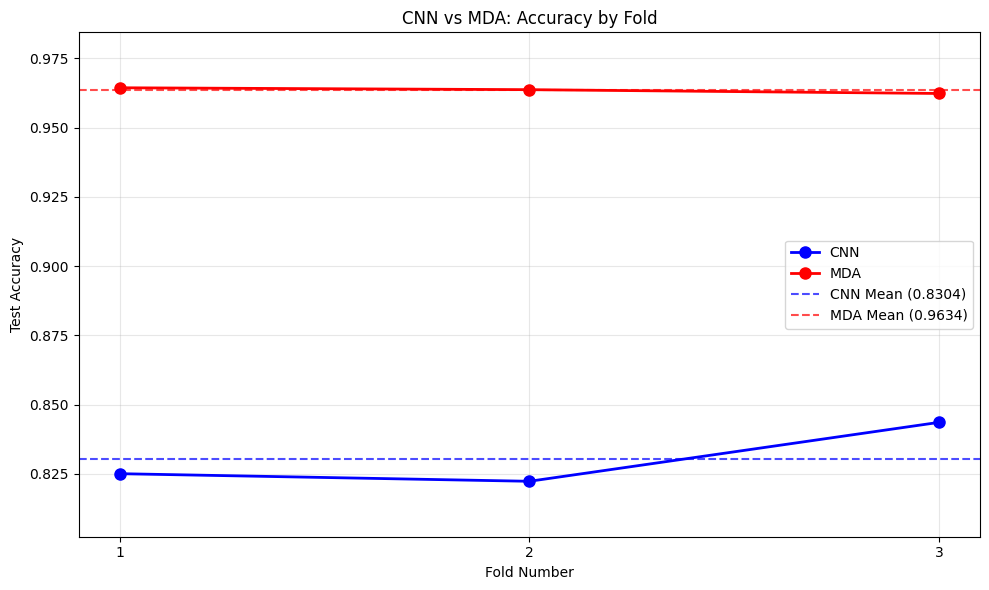

In [24]:
# Calculate statistics
cnn_mean = np.mean(cnn_test_accuracies)
cnn_std = np.std(cnn_test_accuracies)
mda_mean = np.mean(mda_test_accuracies)
mda_std = np.std(mda_test_accuracies)

# Create single plot for fold accuracies
plt.figure(figsize=(10, 6))

# Plot individual fold accuracies
fold_numbers = [result['fold'] for result in cnn_fold_results]
plt.plot(fold_numbers, cnn_test_accuracies, 'bo-', label='CNN', linewidth=2, markersize=8)
plt.plot(fold_numbers, mda_test_accuracies, 'ro-', label='MDA', linewidth=2, markersize=8)

# Add mean lines
plt.axhline(y=cnn_mean, color='blue', linestyle='--', alpha=0.7, label=f'CNN Mean ({cnn_mean:.4f})')
plt.axhline(y=mda_mean, color='red', linestyle='--', alpha=0.7, label=f'MDA Mean ({mda_mean:.4f})')

plt.xlabel('Fold Number')
plt.ylabel('Test Accuracy')
plt.title('CNN vs MDA: Accuracy by Fold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(fold_numbers)

# Set y-axis limits to better show differences
y_min = min(min(cnn_test_accuracies), min(mda_test_accuracies)) - 0.02
y_max = max(max(cnn_test_accuracies), max(mda_test_accuracies)) + 0.02
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()

## Plot mean accuracy with std
This shows the mean and standard deviation of test accuracies for both CNN and MDA across all folds.

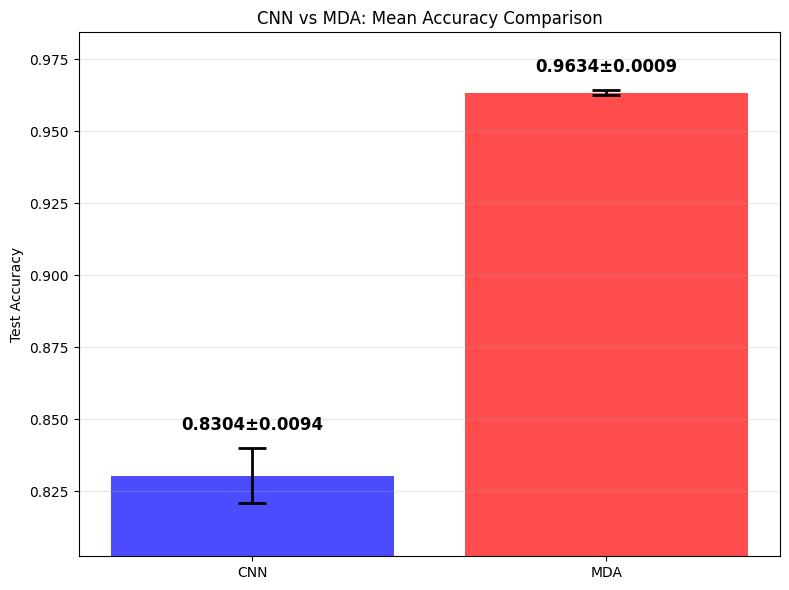

In [25]:
# Create single plot for mean accuracy comparison
plt.figure(figsize=(8, 6))

# Mean accuracy comparison with error bars
methods = ['CNN', 'MDA']
means = [cnn_mean, mda_mean]
stds = [cnn_std, mda_std]
colors = ['blue', 'red']

bars = plt.bar(methods, means, yerr=stds, capsize=10, color=colors, alpha=0.7, 
               error_kw={'linewidth': 2, 'capthick': 2})

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.005, f'{mean:.4f}±{std:.4f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.ylabel('Test Accuracy')
plt.title('CNN vs MDA: Mean Accuracy Comparison')
plt.grid(True, alpha=0.3, axis='y')

# Set y-axis limits to better show differences
y_min = min(min(cnn_test_accuracies), min(mda_test_accuracies)) - 0.02
y_max = max(max(cnn_test_accuracies), max(mda_test_accuracies)) + 0.02
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()

## Paired t-tests
This section performs paired t-tests to assess the statistical significance of the accuracy differences between the CNN and MDA methods across the cross-validation folds.

In [26]:
print(f"CNN  - Mean: {cnn_mean:.4f}, Std: {cnn_std:.4f}")
print(f"MDA  - Mean: {mda_mean:.4f}, Std: {mda_std:.4f}")
print(f"Difference (CNN - MDA): {cnn_mean - mda_mean:.4f}")
print()

t_stat, p_value = ttest_rel(cnn_test_accuracies, mda_test_accuracies)
print(f"Paired t-test results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("The difference is statistically significant (p < 0.05)")
else:
    print("The difference is not statistically significant (p >= 0.05)")

print()
print("Fold-by-fold comparison:")
print("Fold\tCNN\tMDA\tDifference")
print("-" * 35)
for i in range(len(cnn_test_accuracies)):
    diff = cnn_test_accuracies[i] - mda_test_accuracies[i]
    print(f"{i+1}\t{cnn_test_accuracies[i]:.4f}\t{mda_test_accuracies[i]:.4f}\t{diff:+.4f}")

CNN  - Mean: 0.8304, Std: 0.0094
MDA  - Mean: 0.9634, Std: 0.0009
Difference (CNN - MDA): -0.1331

Paired t-test results:
t-statistic: -18.4137
p-value: 0.0029
The difference is statistically significant (p < 0.05)

Fold-by-fold comparison:
Fold	CNN	MDA	Difference
-----------------------------------
1	0.8251	0.9643	-0.1392
2	0.8224	0.9636	-0.1413
3	0.8436	0.9623	-0.1187


## Results Analysis

### Performance Comparison

The MDA pipeline significantly outperformed the CNN approach across all evaluation metrics:

- **MDA achieved 96.34% ± 0.09% accuracy** compared to **CNN's 83.04% ± 0.94% accuracy**
- This represents a substantial **13.31 percentage point improvement** in favor of MDA
- The paired t-test confirmed this difference is **statistically significant** (p = 0.0029, t = -18.41)

### Consistency and Reliability

MDA demonstrated superior consistency across cross-validation folds:

- **MDA showed remarkably low variance** (std = 0.0009) with fold accuracies ranging from 96.23% to 96.43%
- **CNN exhibited higher variability** (std = 0.0094) with fold accuracies ranging from 82.24% to 84.36%

### Method-Specific Insights

**MDA Pipeline:**
- Consistently selected **MLPClassifier as the optimal classifier** across all folds
- Optimal ranks varied between **32 and 64**, indicating successful adaptation to data characteristics
- The tensor decomposition approach effectively captured discriminative features in the GAF representations

**CNN Pipeline Limitations:**
- The **shallow 3-layer architecture** may have been insufficient to capture complex hierarchical patterns in GAF images
- **Limited depth** restricts the network's ability to learn sophisticated feature representations compared to deeper architectures
- The simple CNN design lacks advanced components like **residual connections, attention mechanisms, or batch normalization** that could improve performance
- **Small dataset size** (4,374 samples) may be inadequate for training deep neural networks effectively
- The **fixed architecture** wasn't optimized through extensive hyperparameter search or neural architecture search

### Clinical Significance

For schizophrenia classification, MDA's **96.34% accuracy** represents excellent diagnostic potential with consistent performance across folds, crucial for reliable medical diagnosis.

### Implications

These results highlight that **classical ML with proper dimensionality reduction** can outperform shallow deep learning approaches, particularly when:
- Dataset size is limited
- Traditional feature extraction methods (tensor decomposition) effectively capture signal characteristics
- Computational resources favor simpler, more interpretable models

The CNN's underperformance likely stems from its **architectural simplicity rather than fundamental limitations of deep learning**, suggesting that deeper, more sophisticated networks might bridge this performance gap.

## References
[1] Y. Panagakis et al., ‘Tensor Methods in Computer Vision and Deep Learning’, Proceedings of the IEEE, vol. 109, no. 5, pp. 863–890, 2021, doi: 10.1109/JPROC.2021.3074329.